In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from util.collision_loss import torch_collision_check, NN_constraint_step
from util.zonotope import Zonotope, TorchZonotope
from util.constrained_zonotope import TorchConstrainedZonotope
from util.NN_con_zono import forward_pass_NN_torch, forward_pass_NN_con_zono_torch

# Neural network collision update

In [7]:
# Toy 2 Layer network
# 2 - 10 - 2

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)  
        self.fc2 = nn.Linear(10, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

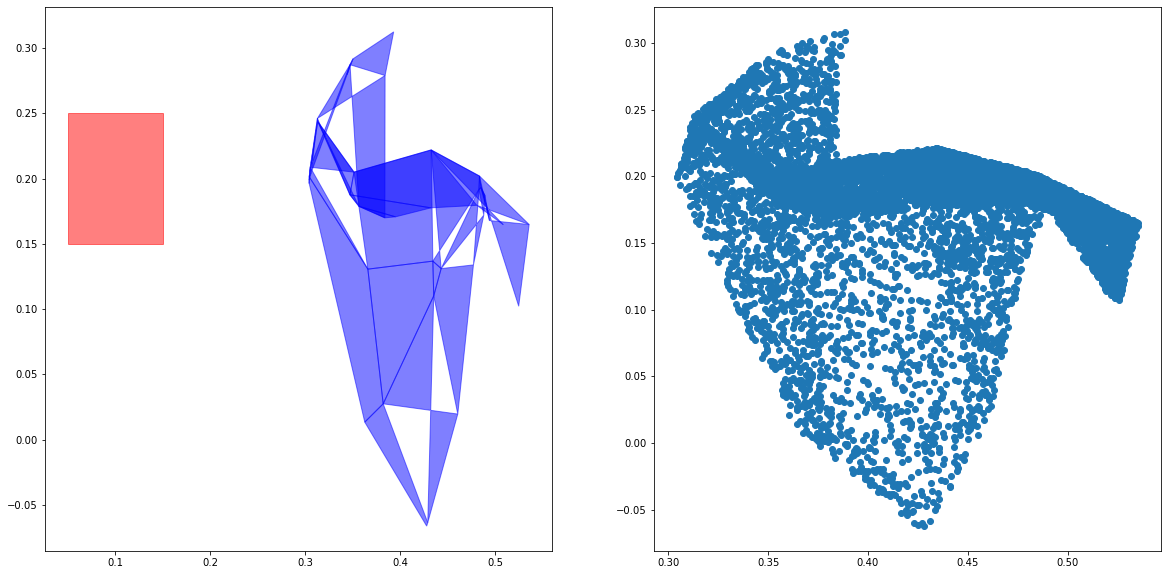

In [8]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1),torch.eye(2))

# output constraint zonotope ("obstacle")
c_obs = torch.tensor([[0.1],[0.2]])
G_obs = torch.diag(torch.tensor([0.05,0.05]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

# compute initial reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

C:\Users\Adam\Anaconda3\envs\reach-net\lib\site-packages\diffcp\cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


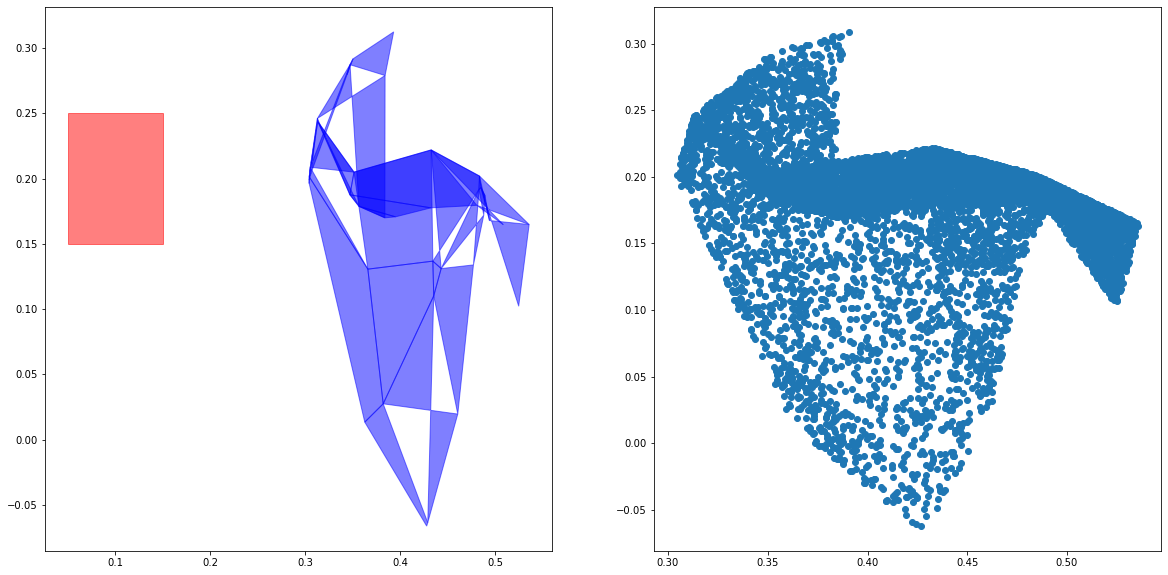

In [9]:
# constraint optimizer
con_opt = optim.SGD(net.parameters(), lr=0.1)

torch.autograd.set_detect_anomaly(True)
# # take a constraint step
NN_constraint_step(Z_in, Z_obs, net, con_opt)

# recompute reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

# Neural network function approximator

In [32]:
# 3 Layer ReLU Feedforward Network
# 2 - 100 - 100 - 2

# n_L1 = 10
# n_L2 = 10

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(2, n_L2)  
#         self.fc2 = nn.Linear(n_L1, n_L2)
#         self.fc3 = nn.Linear(n_L2, 2)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)  
        self.fc2 = nn.Linear(10, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [16]:
# Use nonlinear function to generate data
# nonlinear function (vectorized)
def f_nonl(x):
    return np.array([x[:,0]**2 + np.sin(x[:,1]),
                     x[:,1]**2 + np.sin(x[:,0])])

# training set
N_train = 10000
X_train = np.random.uniform(-1, 1, (N_train,2))

# compute y's
Y_train = f_nonl(X_train)

X_train = torch.as_tensor(X_train, dtype=torch.float)
Y_train = torch.as_tensor(Y_train.T, dtype=torch.float)

In [17]:
# test set
N_test = 10000
X_test = np.random.uniform(-1, 1, (N_test,2))

# compute y's
Y_test = f_nonl(X_test)

X_test = torch.as_tensor(X_test, dtype=torch.float)
Y_test = torch.as_tensor(Y_test.T, dtype=torch.float)

In [18]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X_train)

    output = loss(pred, Y_train)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 

Text(0.5, 1.0, 'Y test pred')

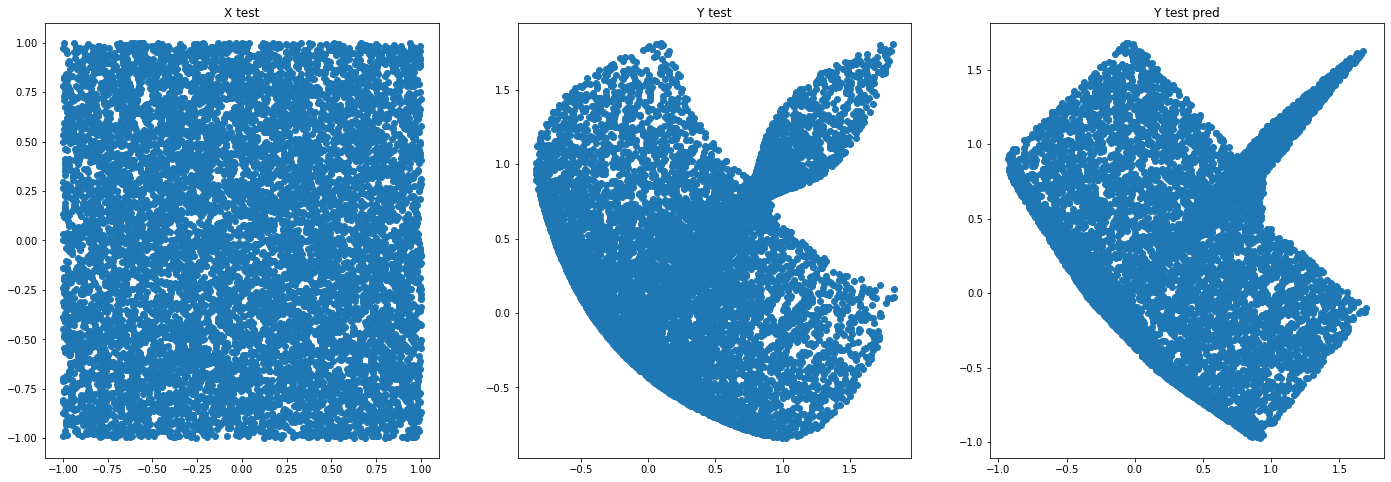

In [19]:
Y_test_pred = net(X_test)
test_loss = loss(Y_test_pred, Y_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
ax1.scatter(X_test[:,0], X_test[:,1]); ax1.set_title('X test')
ax2.scatter(Y_test[:,0], Y_test[:,1]); ax2.set_title('Y test')
ax3.scatter(Y_test_pred[:,0].detach().numpy(), Y_test_pred[:,1].detach().numpy()); ax3.set_title('Y test pred')

# Constrained training
Train function approximator under some obstacle constraints

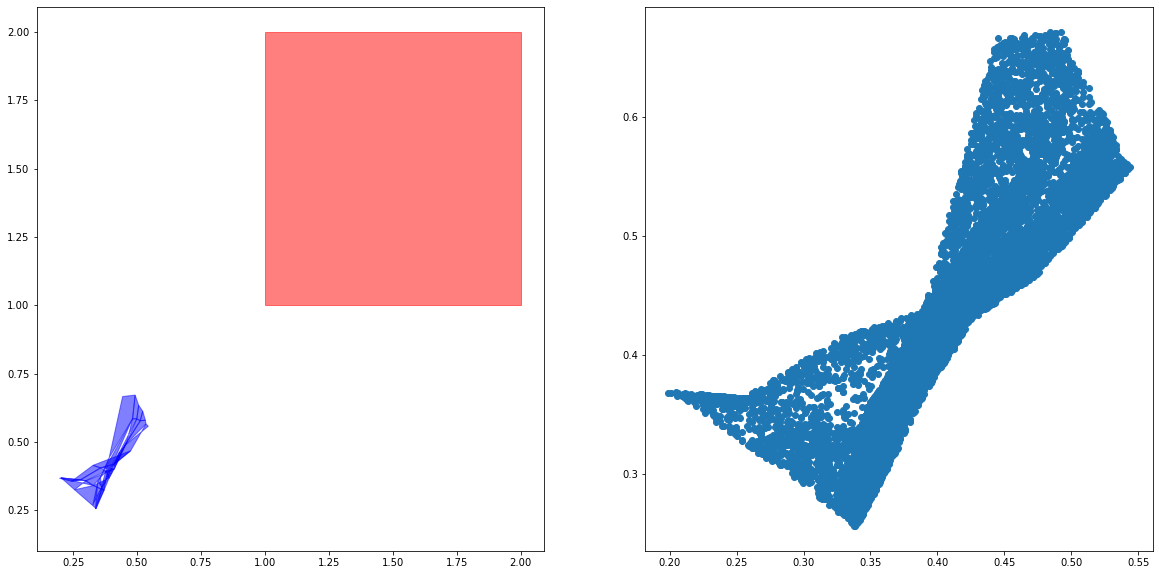

In [33]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1),torch.eye(2))

# output constraint zonotope ("obstacle")
c_obs = torch.tensor([[1.5],[1.5]])
G_obs = torch.diag(torch.tensor([0.5,0.5]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

# compute initial reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

In [34]:
# objective optimizer
obj_opt = optim.SGD(net.parameters(), lr=0.1)

# constraint optimizer
con_opt = optim.SGD(net.parameters(), lr=0.1)

obj = nn.MSELoss()

num_iters = 5

# training loop:
for i in range(num_iters):
    print("iter: ", i)
    # objective update
    obj_opt.zero_grad()   # zero the gradient buffers

    pred = net(X_train)

    obj_loss = obj(pred, Y_train)
    obj_loss.backward()
    obj_opt.step() 

    # constraint update
    NN_constraint_step(Z_in, Z_obs, net, con_opt)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4


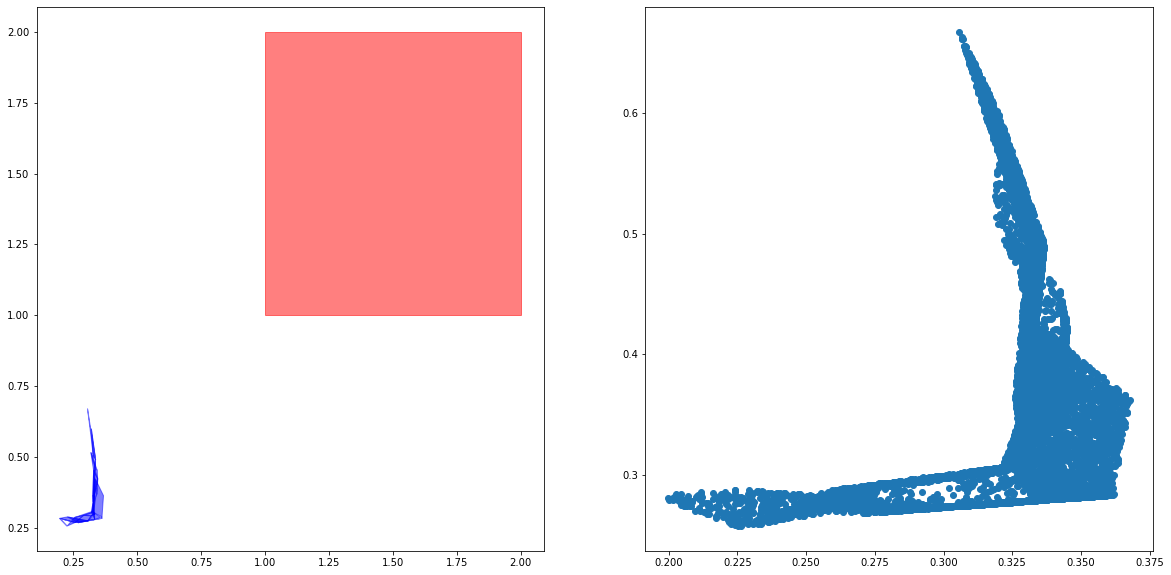

In [35]:
# recompute reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())